# Total Least-Squares

## Imports

In [2]:
import numpy as np

In [3]:
from scipy.odr import Model, Data, ODR

In [4]:
import pandas as pd

In [5]:
import statsmodels.api as sm

In [6]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.collections import EllipseCollection

In [7]:
import plotly.express as px
import plotly.graph_objects as go

### Matplotlib configuration

In [8]:
plt.rc('font',   size=16)          # controls default text sizes
plt.rc('axes',   titlesize=16)     # fontsize of the axes title
plt.rc('axes',   labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick',  labelsize=16)     # fontsize of the tick labels
plt.rc('ytick',  labelsize=16)     # fontsize of the tick labels
plt.rc('legend', fontsize=16)      # legend fontsize
plt.rc('figure', titlesize=16)     # fontsize of the figure title

## The dataset

In [9]:
def myFunc(theta, x):
    return theta[0] * (1-np.exp(-theta[1]*x))

In [10]:
N = 30
rng = np.random.default_rng(1341234)
x0 = np.linspace(0, 4.5, N)
y0 = myFunc([1.0, 1.0], x0)
sigmax = 0.1
sigmay = 0.1
true_xerrors = rng.normal(0.0, sigmax, len(x0))
true_yerrors = rng.normal(0.0, sigmay, len(x0))
x = x0 + true_xerrors
y = y0 + true_yerrors
xerrors = np.ones_like(x) * sigmax
yerrors = np.ones_like(y) * sigmay

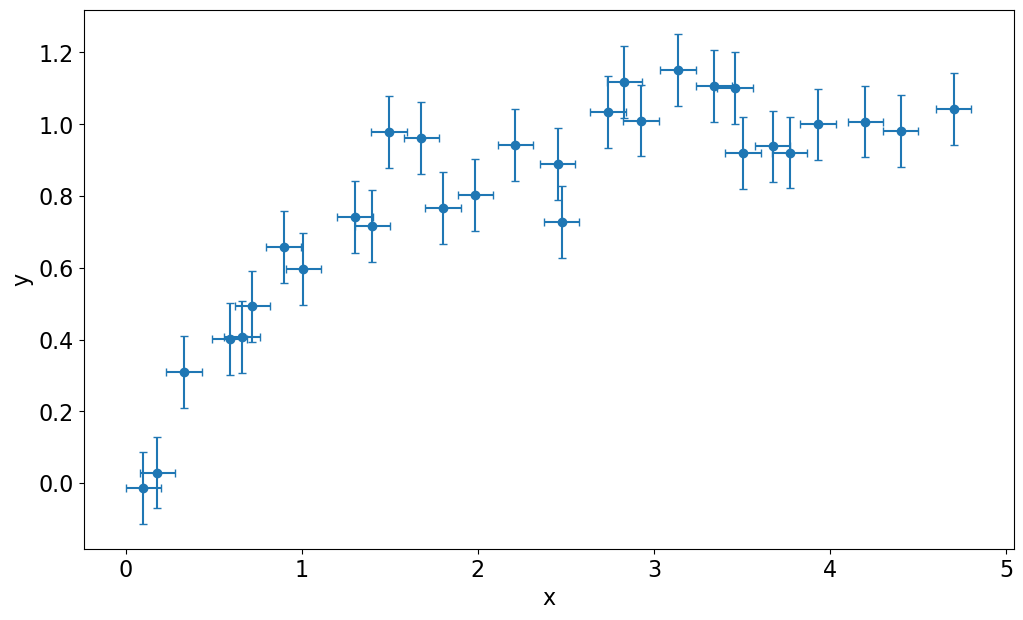

In [11]:
fig, ax = plt.subplots(1,1, figsize=(12,7))
ax.errorbar(x, y, xerr=sigmax, yerr=sigmay, marker="o", linestyle='', capsize=3)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

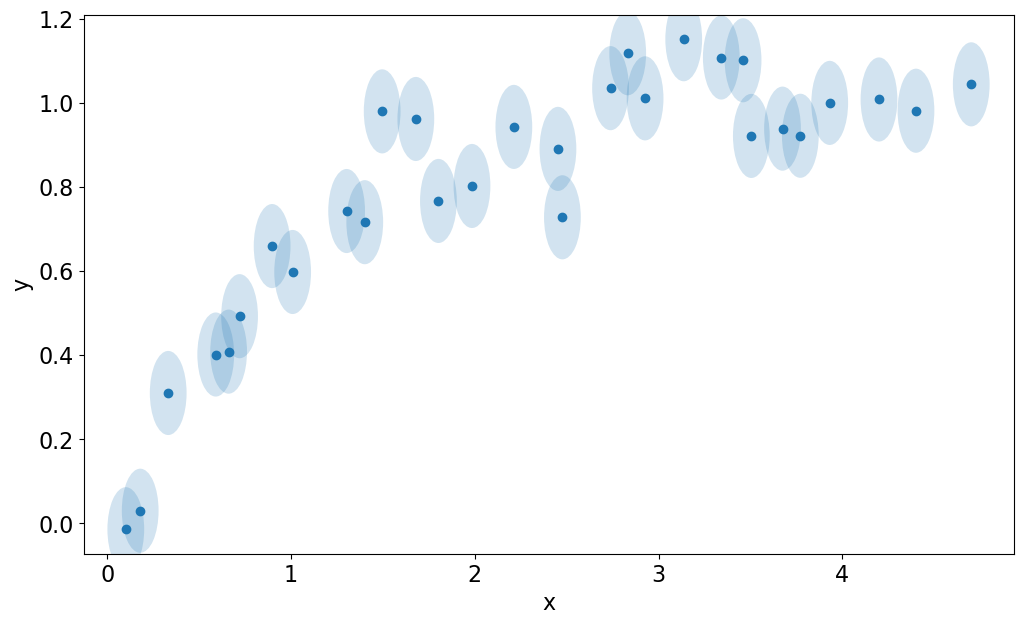

In [12]:
fig, ax = plt.subplots(1,1, figsize=(12,7))
ax.scatter(x, y, marker="o")

xwidth = 2 * xerrors
ywidth = 2 * yerrors
angles = np.zeros_like(x)
xy = np.column_stack((x,y))
ec = EllipseCollection(xwidth, ywidth, angles, units='xy', offsets=xy, transOffset=ax.transData, alpha=0.2)
ax.add_collection(ec)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

### Orthogonal distance regression

For ODR the fit function needs to take the fit parameters as the first argument, and the independent variable as the second argument. 

In [13]:
def myFunc(theta, x):
    return theta[0] * (1-np.exp(-theta[1]*x))

In [14]:
myModel = Model(myFunc)

In [15]:
myData = Data(x, y, wd=1./xerrors**2, we=1./yerrors**2)

In [16]:
initialGuess = [0.5, 0.5]
myFit = ODR(myData, myModel, beta0=initialGuess)

In [17]:
result = myFit.run()

`result` has a pretty-print method. Pretty it ain't, but it's useful. 

In [18]:
result.pprint()

Beta: [1.05038564 0.93394313]
Beta Std Error: [0.03673788 0.11408801]
Beta Covariance: [[ 0.00155808 -0.00393077]
 [-0.00393077  0.01502592]]
Residual Variance: 0.8662412150629714
Inverse Condition #: 0.1672833894722437
Reason(s) for Halting:
  Sum of squares convergence


WARNING: the covariance matrix as stated above is actually **not** correct. See the lines below, on how to properly compute it.

The fit parameters, their standard errors, and the covariance matrix:

In [19]:
best_fit_parameters = result.beta
print(best_fit_parameters)

[1.05038564 0.93394313]


In [20]:
standard_errors = result.sd_beta
print(standard_errors)

[0.03673788 0.11408801]


To compute the covariance, you use `cov_beta` but you still have to multiply it with the variance of the residuals $s^2$ which is available as `res_var`.

In [21]:
covariance_matrix = result.res_var * result.cov_beta
print(covariance_matrix)

[[ 0.00134967 -0.003405  ]
 [-0.003405    0.01301607]]


Only with `res_var` the square root of the diagonal of the resulting matrix equals the standard errors:

In [22]:
print(np.sqrt(covariance_matrix.diagonal()))

[0.03673788 0.11408801]


The estimated errors $\delta$ of the input (x) variables, and the estimated residuals $\epsilon$ of the response variables:

In [23]:
result.delta, result.eps

(array([-5.50833296e-02, -6.66575642e-02,  1.39442860e-02, -3.19634800e-02,
        -1.91681165e-02, -8.91473917e-03,  2.22385565e-02, -1.47744502e-02,
         7.92645949e-04, -1.27531754e-02,  4.16674617e-02,  2.48787173e-02,
        -1.59342199e-02, -1.27674759e-02,  3.03339051e-03, -2.14948160e-02,
        -5.34567449e-03,  4.91610163e-03,  9.72781260e-03,  1.77646456e-03,
         8.11380696e-03,  4.44171623e-03,  3.54084884e-03, -3.34251494e-03,
        -2.84940735e-03, -2.48648132e-03, -6.06849928e-04, -4.30260005e-04,
        -8.44270557e-04,  7.41786657e-05]),
 array([ 0.05862041,  0.07550331, -0.0196342 ,  0.05861435,  0.03331672,
         0.0176587 , -0.05350903,  0.03811961, -0.00272991,  0.04755655,
        -0.17859596, -0.12456641,  0.08614119,  0.08210231, -0.02448825,
         0.21706832,  0.05357503, -0.06498658, -0.14094722, -0.0279071 ,
        -0.15603378, -0.10303694, -0.09167447,  0.08967287,  0.09809829,
         0.07822038,  0.02430877,  0.0221413 ,  0.05241204,

In [24]:
result.sum_square, result.sum_square_delta, result.sum_square_eps

(24.254754021763194, 1.3535150932940307, 22.901238928469162)

To plot the best-fit curve, the following quantities are useful. `xplus` is $x +\delta$, while `y` is computed as $f(\beta_{\rm best}, x+\delta)$.

In [25]:
result.xplus

array([0.04605364, 0.11283889, 0.34583348, 0.62871821, 0.57135171,
       0.71131642, 0.91958695, 0.99433436, 1.3036007 , 1.38871868,
       1.53785835, 1.70427746, 1.7863889 , 1.9722216 , 2.21577492,
       2.45550523, 2.44736635, 2.74384084, 2.84206918, 2.9286484 ,
       3.14521994, 3.34603559, 3.46364093, 3.50172174, 3.76879248,
       3.67221064, 3.93096776, 4.19920042, 4.40008961, 4.70183727])

In [26]:
result.y

array([0.04422083, 0.10506181, 0.28992539, 0.46648805, 0.43435134,
       0.50983757, 0.60538722, 0.63539295, 0.73950043, 0.76325756,
       0.80059068, 0.83654856, 0.85233415, 0.88388988, 0.91776338,
       0.94436748, 0.94355854, 0.96939599, 0.97649533, 0.98223493,
       0.99471482, 1.00423523, 1.00903578, 1.01048056, 1.01928977,
       1.01635447, 1.02366029, 1.02958262, 1.03314138, 1.03737634])

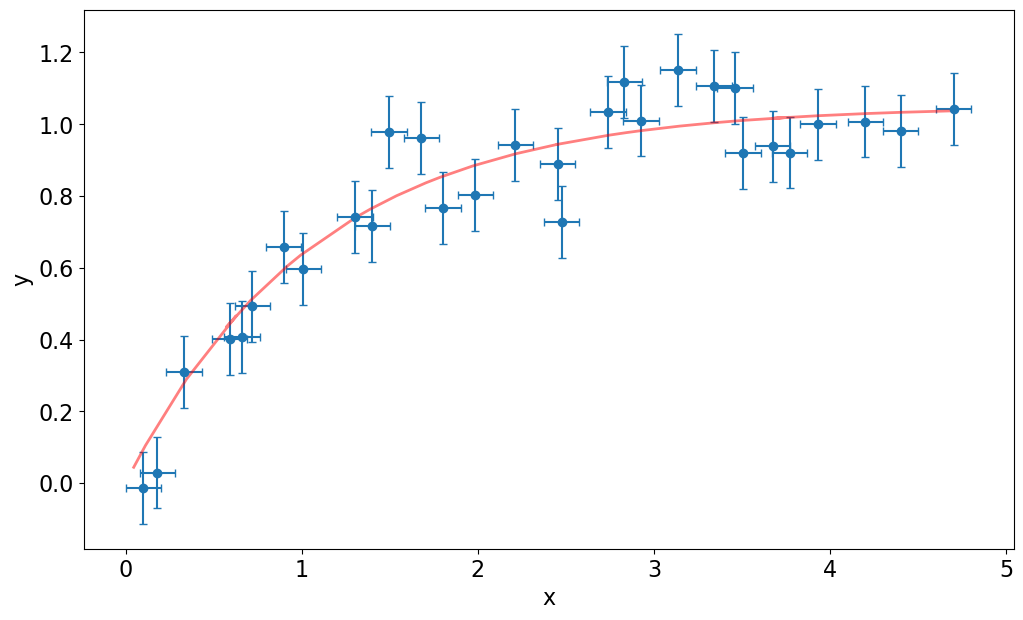

In [27]:
fig, ax = plt.subplots(1,1, figsize=(12,7))
ax.errorbar(x, y, xerr=sigmax, yerr=sigmay, marker="o", linestyle='', capsize=3)
ax.plot(result.xplus, result.y, c="red", linewidth=2, alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

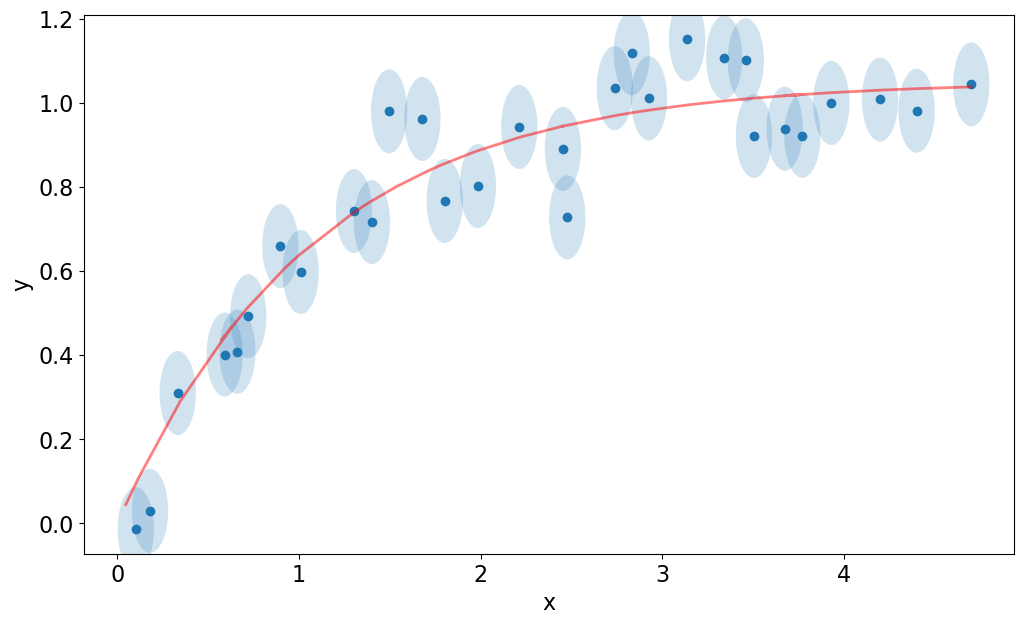

In [28]:
fig, ax = plt.subplots(1,1, figsize=(12,7))
ax.scatter(x, y, marker="o")
ec = EllipseCollection(xwidth, ywidth, angles, units='xy', offsets=xy, transOffset=ax.transData, alpha=0.2)
ax.add_collection(ec)
ax.plot(result.xplus, result.y, c="red", linewidth=2, alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

Finally, the inverse condition number:

In [29]:
result.inv_condnum

0.1672833894722437

## A multivariate example

### Create a synthetic dataset

In [30]:
rng = np.random.default_rng(37)
N = 50
x1true = rng.uniform(0., 10, N)
x2true = rng.uniform(0., 10, N)
sigmax1, sigmax2 = 1, 1
deltax1 = rng.normal(0.0, sigmax1, N)
deltax2 = rng.normal(0.0, sigmax2, N)
x1obs = x1true+deltax1
x2obs = x2true+deltax2
ytrue = 1 + 0.5 * x1true + 0.5 * x2true
sigmay = 0.5
epsilon = rng.normal(0, sigmay, N)
yobs = ytrue + epsilon

In [31]:
df = pd.DataFrame({'y': yobs, 'x1': x1obs, 'x2': x2obs})

In [32]:
fig = px.scatter_3d(df, x='x1', y='x2', z='y', width=750, height=750)
fig.show()

### ODR fit

In [33]:
def myFunc2(theta, X):
    return theta[0] + theta[1] * X[0] + theta[2] * X[1]

In [34]:
myModel = Model(myFunc2)

In [35]:
X = np.stack([x1obs, x2obs])
weightX = np.stack([np.ones(N)/sigmax1**2, np.ones(N)/sigmax2**2])
weightY = np.ones(N)/sigmay**2
myData = Data(X, yobs, wd=weightX, we=weightY)

In [36]:
myFit = ODR(myData, myModel, beta0=[1, 1, 1])

In [37]:
result = myFit.run()

In [38]:
result.pprint()

Beta: [0.95030353 0.57219124 0.44933486]
Beta Std Error: [0.3225029  0.0430346  0.04544836]
Beta Covariance: [[ 1.00556023e-01 -8.45194338e-03 -9.76404439e-03]
 [-8.45194338e-03  1.79050884e-03  5.96005425e-05]
 [-9.76404439e-03  5.96005425e-05  1.99699604e-03]]
Residual Variance: 1.0343300830590172
Inverse Condition #: 0.05401301236028709
Reason(s) for Halting:
  Sum of squares convergence


#### Compare with a WLS model

In [39]:
X = np.column_stack([x1obs, x2obs])
X = sm.add_constant(X)
weightY = np.ones(N)/sigmay**2
myModel2 = sm.WLS(yobs, X, weights=weightY)

In [40]:
myFit2 = myModel2.fit()

In [41]:
myFit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.840
Model:                            WLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     123.3
Date:                Fri, 23 Feb 2024   Prob (F-statistic):           2.02e-19
Time:                        16:24:27   Log-Likelihood:                -62.048
No. Observations:                  50   AIC:                             130.1
Df Residuals:                      47   BIC:                             135.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4822      0.300      4.937      0.000       0.878       2.086
x1             0.5116      0.040     12.655      0.000       0.430       0.593
x2             0.3956      0.043      9.202      0.000       0.309       0.482
==============================================================================
Omnibus:                        1.622   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.444   Jarque-Bera (JB):                1.131
Skew:                           0.003   Prob(JB):                        0.568
Kurtosis:                       2.263   Cond. No.                         18.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""